### Initialisation

Here we set the google drive access, import the required libraries and load the dataset.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!pip install tensorboardx
!pip install segyio

     |████████████████████████████████| 225kB 9.3MB/s 


In [0]:
import scipy.misc
import os
#os.chdir("../")
import segyio
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import matplotlib

In [0]:
def seismic_display(seismic_image, figsize = (14,8.75), grid = True, cmap = 'seismic', ticks = None): 
  plot_range_min1 = np.min(original_cube_amplitudes[0])
  plot_range_max1 = np.max(original_cube_amplitudes[0])
  norm1 = matplotlib.colors.Normalize(vmin=plot_range_min1, vmax=plot_range_max1)

  fig, ax = plt.subplots(figsize=figsize)
  im = plt.imshow(seismic_image.T, cmap=cmap)
  ax = plt.gca()
  if grid is True:
    ax.grid(color='black', linestyle='-', linewidth=0.5)
  plt.colorbar(im, ticks= ticks, spacing = 'uniform')

## Load the Dataset

In [0]:
!cp "/content/gdrive/My Drive/Forties/data/malenov/CNN_data/De_noised_Seismic___9_1562332244893.sgy" "De_noised_Seismic_cube_Forties___9_1561024414129.sgy"
!cp "/content/gdrive/My Drive/Forties/data/malenov/CNN_data/Por_Labels_1562331649850.sgy" "Por_Labels_1562324680441.sgy"

In [0]:
normalize = True;

# Amplitudes
sgycube = 'De_noised_Seismic_cube_Forties___9_1561024414129.sgy'
# Labels
sgylabels = 'Por_Labels_1562324680441.sgy'

amplitude_inlines = []
with segyio.open(sgycube, "r") as segyfile:

    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    
    for inline in segyfile.ilines:
        amplitude_inlines.append(segyfile.iline[inline])

amplitude_inlines = np.array(amplitude_inlines)

# original cube amplitudes
# --- 
original_cube_amplitudes = np.copy(amplitude_inlines)
if normalize == True:
  original_cube_amplitudes = (original_cube_amplitudes - np.mean(original_cube_amplitudes))/np.std(original_cube_amplitudes)
# ---

label_inlines = []
with segyio.open(sgylabels, "r") as segyfile:

    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    
    for inline in segyfile.ilines:
        label_inlines.append(segyfile.iline[inline])

label_inlines = np.array(label_inlines)

# original cube labels
# --- 
original_cube_labels = np.copy(label_inlines)
# --- 

# There were some NAN labels in the original labels (at the very bottom and top of the images)
# label NaNs in labels as either 1 or 5
# ---
for i in range(original_cube_labels.shape[0]):
    for k in range(original_cube_labels.shape[2]):
         
        if (k>230):
            original_cube_labels[i,:,k] = 5
        if (k<50):
            original_cube_labels[i,:,k] = 1
# ---

**Pad the cube (reflective)**

This is needed so that the prediction is the same size as the input (we can't extract patches near the edges of the cube where the distance between the pixels and the edge  is less than that of the half patch size).

In [0]:
import os
#os.chdir("../")
import segyio
import numpy as np
from shutil import copyfile

#inlines = np.array(inlines)

# original cube
original_cube = np.copy(original_cube_amplitudes)

# add mirror padding
padded_cube_reflect = np.pad(original_cube, ((32,32),(32,32),(32,32)), 'reflect')
padded_cube_reflect_labels = np.pad(original_cube_labels, ((32,32),(32,32),(32,32)), 'reflect')

print('Original Cube Shape', original_cube_amplitudes.shape)
print('Padded Amplitudes Cube Shape', padded_cube_reflect.shape)
print('Padded Labels Cube Shape', padded_cube_reflect_labels.shape)

#np.save("/content/gdrive/My Drive/Forties/data/malenov/Forties_Symmetric_Padded_32_Cube.npy", np.expand_dims(padded_cube_reflect, 3).astype(np.int16))
np.save("/content/gdrive/My Drive/Forties/data/malenov/Padded_32_Cube.npy", np.expand_dims(padded_cube_reflect, 3).astype(np.int16))

Original Cube Shape (401, 401, 251)
Padded Amplitudes Cube Shape (465, 465, 315)
Padded Labels Cube Shape (465, 465, 315)


Get indices and labels to train

In [0]:
def get_indices_labels(inline, inline_number=100):

    """
    From labelled inline get labels and their indices on the seismic Cube
    """
    
    labels = []
    indices = []

    for x_index in range(inline.shape[1]):
        for y_index in range(inline.shape[2]):
            
            if (inline[inline_number, x_index, y_index]) != 0:
                labels.append(inline[inline_number, x_index, y_index]);
            else: print("invalid labels");
            
            index = [inline_number, x_index, y_index];
            indices.append(index);

    return (np.array(indices), np.array(labels))

In [0]:
# Training Set (we use 8 inline slices only)
train_indices1,train_labels1 = get_indices_labels(original_cube_labels, inline_number=0)
train_indices2,train_labels2 = get_indices_labels(original_cube_labels, inline_number=60)
train_indices3,train_labels3 = get_indices_labels(original_cube_labels, inline_number=120)
train_indices4,train_labels4 = get_indices_labels(original_cube_labels, inline_number=180)
train_indices5,train_labels5 = get_indices_labels(original_cube_labels, inline_number=240)
train_indices6,train_labels6 = get_indices_labels(original_cube_labels, inline_number=300)
train_indices7,train_labels7 = get_indices_labels(original_cube_labels, inline_number=360)
train_indices8,train_labels8 = get_indices_labels(original_cube_labels, inline_number=400)

train_labels = np.hstack((train_labels1, train_labels2, train_labels3, train_labels4, train_labels5, train_labels6, train_labels7, train_labels8))
train_indices = np.vstack((train_indices1, train_indices2, train_indices3, train_indices4, train_indices5, train_indices6, train_indices7, train_indices8))

print(train_labels.shape)
print(train_indices.shape)

(805208,)
(805208, 3)


In [0]:
np.save("/content/gdrive/My Drive/Forties/data/malenov/train_labels.npy", train_labels)
np.save("/content/gdrive/My Drive/Forties/data/malenov/train_indices.npy", train_indices)

## Utils (don't run those cells)
This displays the python files (in Forties folder) that are run on the command line below. This is only for convinience.

In [0]:
# dataset.py
from torch.utils.data.dataset import Dataset
import numpy as np

# function used for data augmentation
def tranformer(img):
    '''
    implement 3d data augmentations here if desired
    e.g.
    
    # switch x and y and z axis
    # ---
    Random = np.random.randint(10)
    if(Random < 5):
    	img1 = img.transpose(2, 3)
    else:
        img1 = img

    
    Random2 = np.random.randint(10)
    if(Random >= 5):
    	img2 = img1.transpose(2, 1)
    else:
        img2 = img1
    
    
    return img2 
    '''
  
    return img
    # ---



class MalenovDataset(Dataset):
    def __init__(self, seismic, indices, labels, cube_size, transform=None):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = indices
        self.labels = labels
        self.count = len(self.labels)
        self.transform = transform
        
    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[:, idx[0]-self.cube_size:idx[0]+self.cube_size+1, 
                            idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                            idx[2]-self.cube_size:idx[2]+self.cube_size+1]
        
        label = self.labels[index]
        if self.transform:
            img = tranformer(img)

        return (img, label)

    def __len__(self):
        return self.count # of how many examples(images?) you have


class MalenovTestDataset(Dataset):
    def __init__(self, seismic, inline, cube_size):
        self.seismic = seismic
        self.cube_size = cube_size

        self.indices = []
        self.amplitudes = []
        for i in range(self.seismic.shape[2]):
            for j in range(self.seismic.shape[3]):
                if cube_size <= i < seismic.shape[2]-cube_size and cube_size <= j < seismic.shape[3]-cube_size:
                    idx = [inline, i, j]
                    self.indices.append(idx)
                    self.amplitudes.append(self.seismic[:, idx[0], idx[1], idx[2]])
        self.count = len(self.indices)
                
    
    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[:, idx[0]-self.cube_size:idx[0]+self.cube_size+1, 
                            idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                            idx[2]-self.cube_size:idx[2]+self.cube_size+1]
        return img
      

    def __len__(self):
        return self.count # of how many examples(images?) you have

class MalenovTestDataset_all(Dataset):
    def __init__(self, seismic, inline, cube_size):
        self.seismic = seismic
        self.cube_size = cube_size

        self.indices = []
        self.amplitudes = []
        for k in range(self.seismic.shape[2]):   
            for i in range(self.seismic.shape[2]):
                for j in range(self.seismic.shape[3]):
                    if cube_size <= i < seismic.shape[2]-cube_size and cube_size <= j < seismic.shape[3]-cube_size:
                        idx = [k, i, j]
                        self.indices.append(idx)
                        self.amplitudes.append(self.seismic[:, idx[0], idx[1], idx[2]])
        self.count = len(self.indices)
        
    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[:, idx[0]-self.cube_size:idx[0]+self.cube_size+1, 
                            idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                            idx[2]-self.cube_size:idx[2]+self.cube_size+1]
        return img
      

    def __len__(self):
        return self.count # of how many examples(images?) you have

In [0]:
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class MalenovNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 50, kernel_size=5, stride=4, padding=2)
        self.bn1 = nn.BatchNorm3d(50)
        self.drop1 = nn.Dropout3d(0)

        
        self.conv2 = nn.Conv3d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm3d(50)        
        self.drop2 = nn.Dropout3d(0.2)
        
        self.conv3 = nn.Conv3d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm3d(50)  
        self.drop3 = nn.Dropout3d(0.2)
            
        self.conv4 = nn.Conv3d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm3d(50)          
        self.drop4 = nn.Dropout3d(0.2)
        
        self.conv5 = nn.Conv3d(50, 50, kernel_size=3, stride=2, padding=1)
        self.drop5 = nn.Dropout3d(0)
  
        
        self.linear1 = nn.Linear(400, 50)
        self.bn_ln1 = nn.BatchNorm1d(50)
        self.drop_ln1 = nn.Dropout(0)

        self.linear2 = nn.Linear(50, 10)
        self.bn_ln2 = nn.BatchNorm1d(10)
        self.drop_ln2 = nn.Dropout(0)

        
        self.logits = nn.Linear(10, 5)
        self.bn_logits = nn.BatchNorm1d(5)
        self.drop_logits = nn.Dropout(0)



    def forward(self, x):
        x = F.relu(self.bn1(self.drop1(self.conv1(x))))
        x = F.relu(self.bn2(self.drop2(self.conv2(x))))
        x = F.relu(self.bn3(self.drop3(self.conv3(x))))   
        x = F.relu(self.bn4(self.drop4(self.conv4(x)))) 
        x = self.drop5(self.conv5(x))
        x = x.view(-1, 400)
        x = F.relu(self.bn_ln1(self.drop_ln1(self.linear1(x))))
        x = F.relu(self.bn_ln2(self.drop_ln2(self.linear2(x))))
        logits = self.bn_logits(self.drop_logits(self.logits(x)))
        return logits

In [0]:
# options.py
import argparse 
import os
import datetime
import json

from tensorboardX import SummaryWriter

def get_args():
    parser = argparse.ArgumentParser()
    # Dataset configuration
    parser.add_argument('--data_root', type=str, default='../data/malenov/',
                        help='path to dataset root directory. default: ../data/malenov/')
    parser.add_argument('--batch_size', '-B', type=int, default=32,
                        help='mini-batch size of training data. default: 32')
    parser.add_argument('--num_workers', type=int, default=2,
                        help='Number of workers for training data loader. default: 2')

    # Optimizer settings
    parser.add_argument('--lr', type=float, default=0.01,
                        help='Initial learning rate of Adam. default: 0.01')
    parser.add_argument('--beta1', type=float, default=0.5,
                        help='beta1 (betas[0]) value of Adam. default: 0.5')
    parser.add_argument('--beta2', type=float, default=0.9,
                        help='beta2 (betas[1]) value of Adam. default: 0.9')

    # Training setting
    parser.add_argument('--seed', type=int, default=42,
                        help='Random seed. default: 42 (derived from Douglas Adams)')
    parser.add_argument('--epochs', '-E', type=int, default=10,
                        help='Max epoch number of training. default: 10')
    parser.add_argument('--cube_size', '-cs', type=int, default=32,
                        help='Size of input cube. default: 32')
    parser.add_argument('--train_size', '-ts', type=float, default=0.8,
                        help='Size of training split in range 0 to 1. default: 0.8')
    parser.add_argument('--use_stratified_kfold', '-strat', default=False, action='store_true',
                        help='If true use stratified kfold, else use left right split of training image. default: True')
    parser.add_argument('--num_examples', '-ne', type=int, default=10000,
                        help='Number of examples in an epoch. default: 10000')

    # Log and Save interval configuration
    parser.add_argument('--results_root', type=str, default='results',
                        help='Path to results directory. default: results')
    parser.add_argument('--checkpoint_interval', '-ci', type=int, default=1,
                        help='Interval of saving checkpoints (model and optimizer). default: 1')
    parser.add_argument('--log_interval', '-li', type=int, default=1,
                        help='Interval of showing losses. default: 100')
    # Resume training
    parser.add_argument('--args_path', default=None, help='Checkpoint args json path. default: None')
    parser.add_argument('--checkpoint_path', '-mcp', default=None,
                        help='Model and optimizer checkpoint path. default: None')
    
    #Test Time
    parser.add_argument('--inline', default=230, type=int, help='Set inline for prediction')
    args = parser.parse_args()

    args.results_root = os.path.expandvars(args.results_root)
    args.data_root = os.path.expandvars(args.data_root)
    return args

def prepare_output_directory(args):
    time_str = datetime.datetime.now().strftime('%y%m%d_%H%M')
    root = os.path.join(args.results_root, "malenov", time_str)
    os.makedirs(root, exist_ok=True)

    train_writer = SummaryWriter(root+"/train")
    val_writer = SummaryWriter(root+"/val")

    with open(os.path.join(root, 'args.json'), 'w') as f:
        json.dump(args.__dict__, f, indent=2)
    print(json.dumps(args.__dict__, indent=2))
    return args, train_writer, val_writer, time_str


In [0]:
# utils.py
import os
import torch
import shutil
import numpy as np
#from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit


def save_checkpoints(args, epoch, model, optimizer, time_str):
    """Save checkpoints and optimizer"""
    model_dst = os.path.join(
        args.results_root, "malenov", time_str,
        'model_epoch_{}.pth.tar'.format(epoch)
    )
    torch.save({
        'model': model.state_dict(), 'optimizer': optimizer.state_dict(),
    }, model_dst)
    shutil.copy(model_dst, os.path.join(args.results_root, "malenov", time_str, 'model_latest.pth.tar'))


def get_valid_indices_and_labels(index_mins, index_maxs, indices, labels, cube_half_size):
    valid_indices = []
    valid_labels = []
    for index, label in zip(indices, labels):
        if [(index_mins[i]+cube_half_size <= index[i] < index_maxs[i]-cube_half_size) for i in range(1,3)] == [True]*2:
            valid_indices.append(index)
            valid_labels.append(label)
    valid_indices = np.array(valid_indices)
    valid_labels = np.array(valid_labels)
    return valid_indices, valid_labels

def get_train_val_set(data_root="../data/malenov/", use_stratified_kfold=True, cube_size=32, train_size=0.8, seed=42):
    labels = np.load("labels.npy")
    indices = np.load("indices.npy")
    
    index_mins = indices.min(0)
    index_maxs = indices.max(0)
    
    cube_half_size = cube_size
    
    if use_stratified_kfold:
        valid_indices, valid_labels = get_valid_indices_and_labels(index_mins, index_maxs, indices, labels, cube_half_size)
    
        splitter = StratifiedShuffleSplit(n_iter=1, random_state=seed, y=valid_labels, train_size=train_size)
    
        train_index, test_index = [*splitter][0]
        print("Labels in TRAIN:", len(train_index), "Labels in TEST:", len(test_index))
        X_train, X_val = valid_indices[train_index], valid_indices[test_index]
        y_train, y_val = valid_labels[train_index], valid_labels[test_index]
    
    else:
        train_indices, train_labels = np.load("./split/train_split.npy")
        val_indices, val_labels = np.load("./split/val_split.npy")
    
        X_train, y_train = get_valid_indices_and_labels(index_mins, index_maxs, train_indices, train_labels, cube_half_size)
        X_val, y_val = get_valid_indices_and_labels(index_mins, index_maxs, val_indices, val_labels, cube_half_size)
    
    seismic = torch.FloatTensor(np.load("seismic_cube.npy")[:, :, :, 0]).unsqueeze(0)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)
    return seismic, X_train, y_train, X_val, y_val


In [0]:
# Train_Model.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug  5 11:21:08 2019

@author: tayfunkaraderi
"""

import numpy as np
import matplotlib.pyplot as plt
#from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import accuracy_score
from tqdm import tqdm as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from malenov.dataset import MalenovDataset
from malenov.options import prepare_output_directory, get_args
from malenov.model import MalenovNet
from malenov.utils import save_checkpoints

def get_valid_indices_and_labels(index_mins, index_maxs, indices, labels, cube_half_size):
    valid_indices = []
    valid_labels = []
    for index, label in zip(indices, labels):
        if [(index_mins[i]+cube_half_size <= index[i] < index_maxs[i]-cube_half_size) for i in range(1,3)] == [True]*2:
            valid_indices.append(index)
            valid_labels.append(label)
    valid_indices = np.array(valid_indices)
    valid_labels = np.array(valid_labels)
    return valid_indices, valid_labels


def main():
    args = get_args()

    # CUDA setting
    if not torch.cuda.is_available():
        raise ValueError("Doesn't make much sense without a GPU. Expect long training times.")
    
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.backends.cudnn.benchmark = False # To combat randomness

    args, train_writer, val_writer, time_str = prepare_output_directory(args)

    labels = np.load(args.data_root+"train_labels.npy")
    labels = labels-1
    
    print("min, max of labels = ", min(labels),max(labels))

    indices = np.load(args.data_root+"train_indices.npy")

    index_mins = indices.min(0)
    index_maxs = indices.max(0)
        
    cube_half_size = args.cube_size

    valid_indices, valid_labels =  indices, labels # get_valid_indices_and_labels(index_mins, index_maxs, indices, labels, cube_half_size)
    valid_indices[:,0] = valid_indices[:,0] + 32
    valid_indices[:,1] = valid_indices[:,1] + 32
    valid_indices[:,2] = valid_indices[:,2] + 32


    print("min, max of k-fold valid_labels = ", min(valid_labels),max(valid_labels))


    #splitter = StratifiedShuffleSplit(n_iter=1, random_state=args.seed, y=valid_labels, train_size=args.train_size)
    splitter = StratifiedShuffleSplit(n_splits=1, random_state=args.seed, train_size=args.train_size)

    #train_index, test_index = [*splitter][0]
    train_index, test_index = [*splitter.split(X = valid_labels, y=valid_labels)][0]

    print("Labels in TRAIN:", len(train_index), "Labels in TEST:", len(test_index))
    X_train, X_val = valid_indices[train_index], valid_indices[test_index]
    y_train, y_val = valid_labels[train_index], valid_labels[test_index]

    
    seismic = torch.FloatTensor(np.load(args.data_root+"Padded_32_Cube.npy")[:, :, :, 0]).unsqueeze(0)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)

    # MalenovDataset returns img and label from index
    train_dset = MalenovDataset(seismic, X_train, y_train, args.cube_size, transform = True)
    val_dset = MalenovDataset(seismic, X_val, y_val, args.cube_size)

    train_loader = DataLoader(train_dset, shuffle=True, batch_size=args.batch_size, num_workers=args.num_workers)
    val_loader = DataLoader(val_dset, shuffle=True, batch_size=args.batch_size, num_workers=args.num_workers)

    model = MalenovNet()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(args.beta1, args.beta2))

    val_accuracy = []; val_loss = []; train_accuracy = []; train_loss = []; 
    for epoch in range(args.epochs):
        model.train()
        avg_acc = 0.
        avg_loss = 0.
        examples = 0
        for i, (X, y) in enumerate(tqdm(train_loader, total=np.ceil(args.num_examples/args.batch_size))):
            optimizer.zero_grad()
            y_pred = model(X.to(device))
            loss = criterion(y_pred, y.to(device))
            loss.backward()
            avg_loss += loss.detach().item()*X.size(0)
            optimizer.step()
            pred = torch.argmax(F.softmax(y_pred.detach(), 1), 1)
            avg_acc += accuracy_score(y_true=y.cpu().numpy(), y_pred=pred.cpu().numpy())*X.size(0)
            examples += X.size(0)

            if examples >= args.num_examples:
                break

        if epoch % args.log_interval == args.log_interval-1:
            print("Train: Average Loss: ", avg_loss/examples)
            print("Train: Average Accuracy: ", avg_acc/examples)
            train_accuracy.append(avg_acc/examples); train_loss.append(avg_loss/examples);

            train_writer.add_scalar('loss', avg_loss/examples, epoch)
            train_writer.add_scalar('accuracy', avg_acc/examples, epoch)

        model.eval()
        avg_acc = 0.
        avg_loss = 0.
        examples = 0
        with torch.set_grad_enabled(False):
            for i, (X, y) in enumerate(tqdm(val_loader, total=np.ceil(len(val_dset)/(10*args.batch_size)))):
                optimizer.zero_grad()
                y_pred = model(X.to(device))
                loss = criterion(y_pred, y.to(device))
                avg_loss += loss.detach().item()*X.size(0)
                pred = torch.argmax(F.softmax(y_pred.detach(), 1), 1)
                avg_acc += accuracy_score(y_true=y.cpu().numpy(), y_pred=pred.cpu().numpy())*X.size(0)
                
                examples += y.size(0)
                if examples >= len(val_dset)/10:
                    break

        if epoch % args.log_interval == args.log_interval-1:
            print("Val: Average Loss: ", avg_loss/examples)
            print("Val: Average Accuracy: ", avg_acc/examples)

            val_accuracy.append(avg_acc/examples); val_loss.append(avg_loss/examples);

            val_writer.add_scalar('loss', avg_loss/len(val_dset), epoch)
            val_writer.add_scalar('accuracy', avg_acc/len(val_dset), epoch)

        if epoch % args.checkpoint_interval == args.checkpoint_interval-1:
            save_checkpoints(args, epoch, model, optimizer, time_str)
    
        if epoch == (args.epochs-1):
            train_accuracy = np.array(train_accuracy); train_loss = np.array(train_loss);
            val_accuracy = np.array(val_accuracy); val_loss = np.array(val_loss);
            fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
            ax_loss.plot(train_loss, label="Train loss")
            ax_loss.plot(val_loss, label="Validation loss")
            ax_loss.legend(loc='best')
            ax_acc.plot(train_accuracy, label="Train accuracy")
            ax_acc.plot(val_accuracy, label="Validation accuracy")
            ax_acc.legend(loc='best')
            fig.savefig('/content/gdrive/My Drive/Forties/pytorch_melanov/training_figure.png')
            print('saved')

if __name__ == '__main__':
    main()

In [0]:
# predict.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 19 15:14:37 2019

@author: tayfunkaraderi
"""

import numpy as np
import matplotlib.pyplot as plt
# from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import accuracy_score
from tqdm import tqdm as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from malenov.dataset import MalenovTestDataset, MalenovTestDataset_all
from malenov.options import get_args
from malenov.model import MalenovNet


def main():
    args = get_args()

    # CUDA setting
    if not torch.cuda.is_available():
        raise ValueError("Doesn't make much sense without a GPU. Expect long training times.")
    
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.backends.cudnn.benchmark = False #To combat randomness
    
    seismic = torch.FloatTensor(np.load(args.data_root+"Padded_32_Cube.npy")[:, :, :, 0]).unsqueeze(0)

    if (args.inline >= 0):
      test_dset = MalenovTestDataset(seismic, args.inline, args.cube_size)
    if (args.inline == -1):
      test_dset = MalenovTestDataset_all(seismic, args.inline, args.cube_size)
    
    test_loader = DataLoader(test_dset, shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers)

    model = MalenovNet()
    ckpt = torch.load(args.checkpoint_path)
    model.load_state_dict(ckpt['model'])
    model.to(device)

    model.eval()
    avg_acc = 0.
    avg_loss = 0.

    np.save(args.results_root + "indices_"+str(args.inline)+".npy", test_dset.indices)
    np.save(args.results_root + "amplitudes_"+str(args.inline)+".npy", test_dset.amplitudes)
    preds = []
    with torch.set_grad_enabled(False):
        for i, X in enumerate(tqdm(test_loader)):
            y_pred = model(X.to(device))
            preds.extend(torch.argmax(F.softmax(y_pred.detach(), 1), 1).cpu().numpy())
    np.save(args.results_root + "preds_"+str(args.inline)+".npy", np.array(preds))
    

if __name__ == '__main__':
    main()

## Train Model

In [0]:
!cd "/content/gdrive/My Drive/Forties/pytorch_melanov" && ls

 malenov      training_figure_50_epoch.png
 notebooks    training_figure.png
 predict.py   Train_Model.py
 results     'Train_Model.py adlı dosyanın kopyası'
 split	     'Train_Model.py adlı dosyanın kopyası (1)'


The trained models will be saved for every epoch into a file (called the date and time e.g. the name of the file may be 190811_2044) in the results_root specified below. The training figure will be saved into Forties/pytorch_melanov folder and can be displayed in the cell below trianing.

In [0]:
start = time.time()
!cd "/content/gdrive/My Drive/Forties/pytorch_melanov" &&  python  Train_Model.py --epochs 2 --results_root "results/padded_cube_models_bests2_/" --lr 0.01 --use_stratified_kfold --train_size 0.8 --num_examples 100000
end = time.time()
print(end - start)


{
  "data_root": "../data/malenov/",
  "batch_size": 32,
  "num_workers": 2,
  "lr": 0.01,
  "beta1": 0.5,
  "beta2": 0.9,
  "seed": 42,
  "epochs": 2,
  "cube_size": 32,
  "train_size": 0.8,
  "use_stratified_kfold": true,
  "num_examples": 100000,
  "results_root": "results/padded_cube_models_bests2_/",
  "checkpoint_interval": 1,
  "log_interval": 1,
  "args_path": null,
  "checkpoint_path": null,
  "inline": 230
}
min, max of labels =  0.0 4.0
min, max of k-fold valid_labels =  0.0 4.0
Labels in TRAIN: 644166 Labels in TEST: 161042
100% 3124/3125.0 [02:27<00:00, 21.11it/s]Train: Average Loss:  0.16610397040039301
Train: Average Accuracy:  0.94465

  0% 0/504.0 [00:00<?, ?it/s]
  0% 1/504.0 [00:00<01:42,  4.90it/s]
  1% 5/504.0 [00:00<01:16,  6.56it/s]
  2% 9/504.0 [00:00<00:57,  8.65it/s]
  3% 13/504.0 [00:00<00:44, 11.10it/s]
  3% 17/504.0 [00:00<00:35, 13.86it/s]
  4% 21/504.0 [00:00<00:28, 16.72it/s]
  5% 25/504.0 [00:00<00:24, 19.61it/s]
  6% 29/504.0 [00:01<00:21, 22.22it/s]
 

**Accuracy Figure**

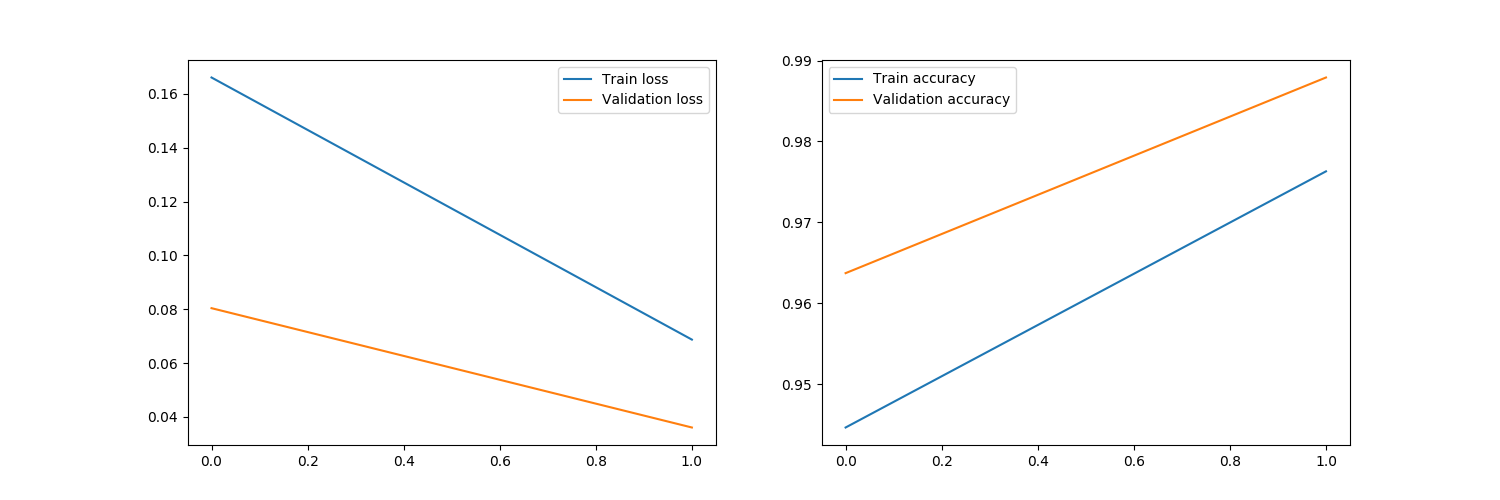

In [0]:
!cp '/content/gdrive/My Drive/Forties/pytorch_melanov/training_figure.png' 'training_figure.png'
from IPython.display import Image
Image('training_figure.png')

## Apply the Model on Another Inline

Below you can predict the pixel labels for another inline slice. The labels will be saved into labels_%inline.npy and the corresponding indices will be saved into indices_%inline.npy. The path for the model to be used in making predictions needs to be specified in the checkpoint_path. The outputs will go into the specified results_root.

In [0]:
# This will create indices,amplitudes and preds .npy files in the results_root
start = time.time()
!cd "/content/gdrive/My Drive/Forties/pytorch_melanov" &&  python  predict.py --inline 264  --results_root ./results/padded_cube_models_bests_/malenov/190811_2044/  --checkpoint_path ./results/padded_cube_models_bests_/malenov/190811_2044/model_latest.pth.tar  --batch_size 64
end = time.time()
print(end - start)


100% 1573/1573 [01:49<00:00, 14.32it/s]
125.44921517372131


## Visualize the Results / Apply CRF 

indices.npy and preds.npy are visualized using plot_prediction

In [0]:
def plot_prediction(ax, seismic, inline, folder, return_prediction = False):
    '''
    Seismic - this is the original amplitudes cube -- used for its shape only
    inline - inline being plotted
    folder - directory where indices and labels.npy files are
    This is used to visualize a predicted segmentation map from indices.npy and preds.npy files
    '''
    indices = np.load(folder+"indices_"+str(inline)+".npy")
    amplitudes = np.load(folder+"amplitudes_"+str(inline)+".npy")

    preds = np.load(folder+"preds_"+str(inline)+".npy")
    img = np.zeros((seismic.shape[1], seismic.shape[2]))

    for index, pred in zip(indices, preds):
        img[index[1]-32, index[2]-32] = pred
    #amplitude_map = seismic[inline-32, :, :]
    #ax.imshow(amplitude_map.T, cmap='seismic', alpha=0)
    if (return_prediction == False):
      ax.imshow(img.T, alpha=1)
    
    if (return_prediction == True):
      return img

Below are used to obtain accuracy (pixelwise/IoU) of our predictions.

In [0]:
def test_accuracy_score(prediction, inline):
  "plots accuracy of each label and the overall accuracy for given inline"
  
  actual_labels = original_cube_labels[inline-32,:,:] - 1

      
  # Pixelwise accuracy score
  Num0=0; Num1=0; Num2=0; Num3=0; Num4=0;
  error0=0; error1=0; error2=0; error3=0; error4=0;

  for j in range(prediction.shape[0]):
    for k in range(prediction.shape[1]):
        if actual_labels[j,k] == 0:
          Num0 += 1
          if (actual_labels[j,k] != prediction[j,k]): error0 += 1;
        
        if actual_labels[j,k] == 1:
          Num1 += 1
          if (actual_labels[j,k] != prediction[j,k]): error1 += 1;
        
        if actual_labels[j,k] == 2: 
          Num2 += 1
          if (actual_labels[j,k] != prediction[j,k]): error2 += 1;
         
        if actual_labels[j,k] == 3:
          Num3 += 1
          if (actual_labels[j,k] != prediction[j,k]): error3 += 1;
        
        if actual_labels[j,k] == 4:
          Num4 += 1
          if (actual_labels[j,k] != prediction[j,k]): error4 += 1;
  
  total_error = error0 + error1 + error2 + error3 + error4
  percentage_error = total_error/(prediction.shape[0]*prediction.shape[1])
  Overall_accuracy = 1 - percentage_error
  label0_accuracy  = 1 - error0/Num0
  label1_accuracy  = 1 - error1/Num1
  label2_accuracy  = 1 - error2/Num2
  label3_accuracy  = 1 - error3/Num3
  label4_accuracy  = 1 - error4/Num4
  
  # All the plots
  fig = plt.figure(figsize=(12, 6))
  #plt.subplot(321)
  plt.ylim(0, 1)
  plt.bar(["overall", "label0", "label1", "label2", "label3", "label4"], [Overall_accuracy, label0_accuracy, label1_accuracy, label2_accuracy, label3_accuracy, label4_accuracy], align='center')
  plt.ylabel("Accuracy")
  fig = plt.figure(figsize=(10, 60))
  fig.tight_layout()
  
  print ("overall accuracy is ", Overall_accuracy)
  print ("label0 accuracy is " , label0_accuracy)
  print ("label1 accuracy is " , label1_accuracy)
  print ("label2 accuracy is " , label2_accuracy)
  print ("label3 accuracy is " , label3_accuracy)
  print ("label4 accuracy is " , label4_accuracy)
  
  return [Overall_accuracy, label0_accuracy, label1_accuracy, label2_accuracy, label3_accuracy, label4_accuracy]

def test_accuracy_score_volume(prediction, actual_labels):
  "plots accuracy of each label and the overall accuracy for the entire volume"
  if (prediction.shape[0:3] != actual_labels.shape[0:3]): print("shape of inputs do not match"); return 0;
  
  # Pixelwise accuracy score
  Num0=0; Num1=0; Num2=0; Num3=0; Num4=0;
  error0=0; error1=0; error2=0; error3=0; error4=0;
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      for k in range(prediction.shape[2]):
        if actual_labels[i,j,k] == 0:
          Num0 += 1
          if (actual_labels[i,j,k] != prediction[i,j,k]): error0 += 1;
        
        if actual_labels[i,j,k] == 1:
          Num1 += 1
          if (actual_labels[i,j,k] != prediction[i,j,k]): error1 += 1;
        
        if actual_labels[i,j,k] == 2: 
          Num2 += 1
          if (actual_labels[i,j,k] != prediction[i,j,k]): error2 += 1;
         
        if actual_labels[i,j,k] == 3:
          Num3 += 1
          if (actual_labels[i,j,k] != prediction[i,j,k]): error3 += 1;
        
        if actual_labels[i,j,k] == 4:
          Num4 += 1
          if (actual_labels[i,j,k] != prediction[i,j,k]): error4 += 1;
  
  total_error = error0 + error1 + error2 + error3 + error4
  percentage_error = total_error/(prediction.shape[0]*prediction.shape[1]*prediction.shape[2])
  Overall_accuracy = 1 - percentage_error
  label0_accuracy  = 1 - error0/Num0
  label1_accuracy  = 1 - error1/Num1
  label2_accuracy  = 1 - error2/Num2
  label3_accuracy  = 1 - error3/Num3
  label4_accuracy  = 1 - error4/Num4
  
  # All the plots
  fig = plt.figure(figsize=(16, 2))
  #plt.subplot(321)
  plt.ylim(0.75, 1)
  plt.bar(["overall", "label0", "label1", "label2", "label3", "label4"], [Overall_accuracy, label0_accuracy, label1_accuracy, label2_accuracy, label3_accuracy, label4_accuracy], align='center')
  plt.ylabel("Accuracy")
  fig = plt.figure(figsize=(10, 60))
  fig.tight_layout()
  
  print ("overall accuracy is ", Overall_accuracy)
  print ("label0 accuracy is " , label0_accuracy)
  print ("label1 accuracy is " , label1_accuracy)
  print ("label2 accuracy is " , label2_accuracy)
  print ("label3 accuracy is " , label3_accuracy)
  print ("label4 accuracy is " , label4_accuracy)
  
  return [Overall_accuracy, label0_accuracy, label1_accuracy, label2_accuracy, label3_accuracy, label4_accuracy]


#iou error
def iou_accuracy(prediction, actual_labels):
  with tf.Session() as sess:
      ypredT = tf.constant(prediction)
      ytrueT = tf.constant(actual_labels)
      iou,conf_mat = tf.metrics.mean_iou(ytrueT, ypredT, num_classes=5)
      sess.run(tf.local_variables_initializer())
      sess.run([conf_mat])
      miou = sess.run([iou])
      print(miou)

In [0]:
# crf library from https://github.com/lucasb-eyer/pydensecrf
!pip install '/content/gdrive/My Drive/pydensecrf'

Processing ./gdrive/My Drive/pydensecrf
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp36-cp36m-linux_x86_64.whl size=2235035 sha256=40b7a60c8ad55df283390959942921d951ccdf2b14c79056cbe7287d4c24c697
  Stored in directory: /tmp/pip-ephem-wheel-cache-ai3gk2wf/wheels/80/c5/63/916bb868352090a8237bc17772193c17f16ee3d29acb7f4396
Successfully built pydensecrf
  Found existing installation: pydensecrf 1.0rc2
    Uninstalling pydensecrf-1.0rc2:
      Successfully uninstalled pydensecrf-1.0rc2


In [0]:
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [0]:
"""
Function which returns the labelled image after applying CRF
"""

#Mask image = segmentaion map which has been labelled by some technique..
def crf(mask_img, sxy, compat):
    
   
    annotated_label = mask_img[:,:]
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 5
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(mask_img.shape[1], mask_img.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=sxy, compat=compat, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 20 steps 
    Q = d.inference(20)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((mask_img.shape[0],mask_img.shape[1]))

Lets visualize some of the predictions. First we load the predictions (indices, labels.npy) we saved into the Forties folder.

In [0]:
# Load predictions to visualize
!cp "/content/gdrive/My Drive/Forties/pytorch_melanov/results/padded_cube_models_bests_/malenov/190811_2044/indices_412.npy" "indices_412.npy"
!cp "/content/gdrive/My Drive/Forties/pytorch_melanov/results/padded_cube_models_bests_/malenov/190811_2044/amplitudes_412.npy" "amplitudes_412.npy"
!cp "/content/gdrive/My Drive/Forties/pytorch_melanov/results/padded_cube_models_bests_/malenov/190811_2044/preds_412.npy" "preds_412.npy"

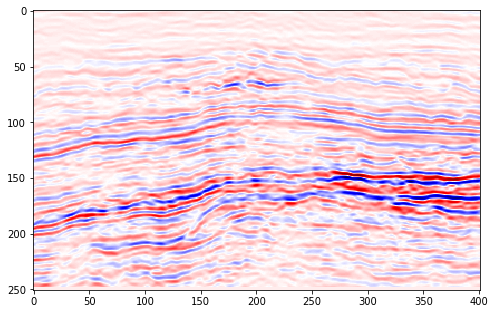

In [0]:
# seismic image
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
plt.imshow(original_cube_amplitudes[90,:,:].T, cmap='seismic')

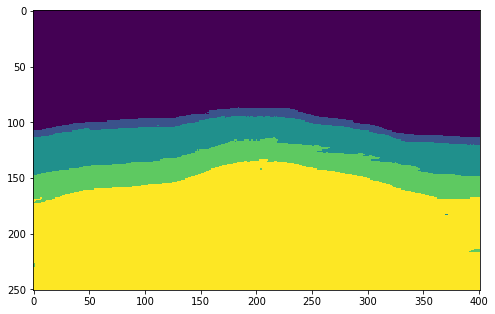

In [0]:
# Predicted Labels (Sliding Window Classifier)
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
plot_prediction(axarr, original_cube_amplitudes, 412, "")

Lets apply CRF model to the prediction

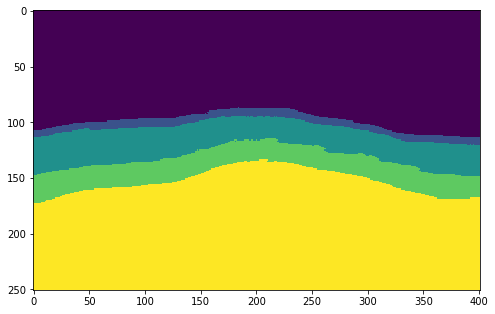

In [0]:
# Predicted Labels after CRF
mask_img = plot_prediction(axarr, original_cube_amplitudes, 412, "", return_prediction = True)
crf_mask_img = crf(mask_img, (3,3), 13)
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
plt.imshow(crf_mask_img.T)

compare to the ground truth

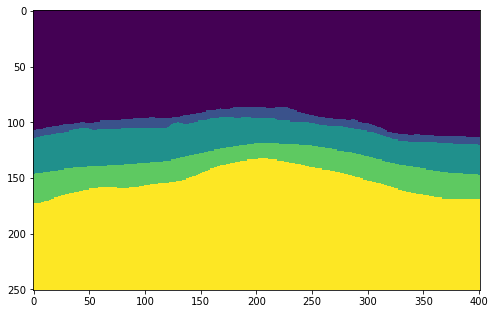

In [0]:
# Ground Truth labels
fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
plt.imshow(original_cube_labels[380,:,:].T)

overall accuracy is  0.9856732670316242
label0 accuracy is  0.998518927603173
label1 accuracy is  0.8843058350100603
label2 accuracy is  0.9515208235844642
label3 accuracy is  0.9538346984363366
label4 accuracy is  0.9962138654387311


[0.9856732670316242,
 0.998518927603173,
 0.8843058350100603,
 0.9515208235844642,
 0.9538346984363366,
 0.9962138654387311]

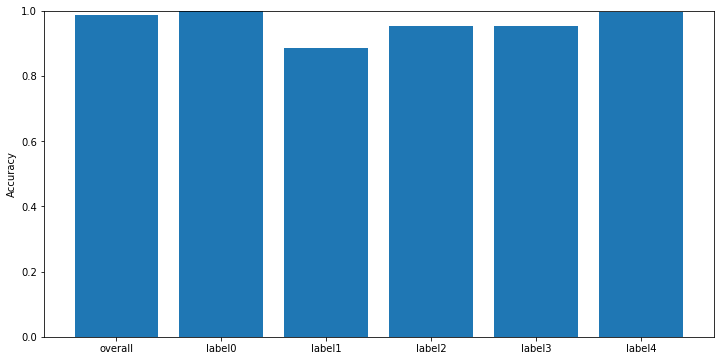

<Figure size 720x4320 with 0 Axes>

In [0]:
# Test accuracy before CRF
test_accuracy_score(mask_img, 412)

overall accuracy is  0.9864084807900567
label0 accuracy is  0.998518927603173
label1 accuracy is  0.8853118712273642
label2 accuracy is  0.9520823584464202
label3 accuracy is  0.958054107719037
label4 accuracy is  0.9970069071373753


[0.9864084807900567,
 0.998518927603173,
 0.8853118712273642,
 0.9520823584464202,
 0.958054107719037,
 0.9970069071373753]

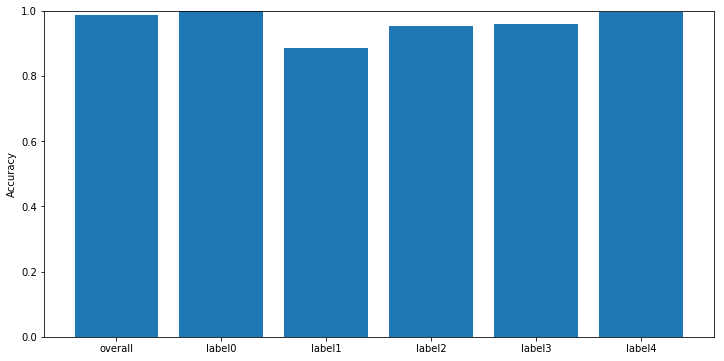

<Figure size 720x4320 with 0 Axes>

In [0]:
# Test accuracy after CRF
test_accuracy_score(crf_mask_img, 412)

In [0]:
#iou accuracy
with tf.Session() as sess:
    ypredT = tf.constant(crf_mask_img)
    ytrueT = tf.constant(original_cube_labels[380,:,:]-1)
    iou,conf_mat = tf.metrics.mean_iou(ytrueT, ypredT, num_classes=5)
    sess.run(tf.local_variables_initializer())
    sess.run([conf_mat])
    miou = sess.run([iou])
    print(miou)

W0828 19:28:13.753889 139779735779200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:1178: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0828 19:28:13.755605 139779735779200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:1179: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


[0.92957944]


## **Predict Entire Volume**
Predicting the entire volume takes a long time. We have done this before and the segmented cube can be loaded directly 5 cells below (no need to run the below 4 cells unless you want to predict using a different model). 

In [0]:
# Note --inline -1 will pass the entire seismic cube which is more efficient but google colab runs out of memory.
# Note that predicting entire volume takes arround 13 hours
for i in range(32, 433):
  !cd "/content/gdrive/My Drive/Forties/pytorch_melanov" &&  python  predict.py --inline  $i  --results_root ./results/padded_cube_models_bests_/malenov/190811_2044/  --checkpoint_path ./results/padded_cube_models_bests_/malenov/190811_2044/model_latest.pth.tar  --batch_size 64

100% 1573/1573 [01:48<00:00, 14.50it/s]
100% 1573/1573 [01:46<00:00, 14.70it/s]
100% 1573/1573 [01:46<00:00, 14.74it/s]
100% 1573/1573 [01:46<00:00, 14.80it/s]
100% 1573/1573 [01:47<00:00, 14.59it/s]
100% 1573/1573 [01:48<00:00, 14.54it/s]
100% 1573/1573 [01:47<00:00, 14.59it/s]
100% 1573/1573 [01:47<00:00, 14.66it/s]
100% 1573/1573 [01:47<00:00, 14.58it/s]
100% 1573/1573 [01:47<00:00, 14.63it/s]
100% 1573/1573 [01:49<00:00, 14.42it/s]
100% 1573/1573 [01:49<00:00, 14.41it/s]


The construct_prediction is used to stack all the predicted labels and their indices inside indices.npy and labels.npy files into a 3D numpy array (the predicted cube).

In [0]:
def construct_prediction(seismic, folder):
    '''
    seismic - original amplitudes cube -- this is only used for its shape
    folder - the path for the indices, labels.npy files that will be merged
    
    returns: numpy array of the constructed cube
    '''
    
    indices = {}
    amplitudes = {}
    preds = {}
    img = {}
    
    for inline in range(32, seismic.shape[0]+32):
      indices["inline{0}".format(inline)] = np.load(folder+"indices_"+str(inline)+".npy")
      amplitudes["inline{0}".format(inline)] = np.load(folder+"amplitudes_"+str(inline)+".npy")
      preds["inline{0}".format(inline)] = np.load(folder+"preds_"+str(inline)+".npy")
      
      img["inline{0}".format(inline)] = np.zeros((seismic.shape[1], seismic.shape[2]))

      for index, pred in zip(indices["inline{0}".format(inline)], preds["inline{0}".format(inline)]):
          img["inline{0}".format(inline)][index[1]-32, index[2]-32] = pred
          
    predicted_cube = np.zeros((seismic.shape[0], seismic.shape[1], seismic.shape[2]))
    for inline in range(predicted_cube.shape[0]):
        predicted_cube[inline] = img["inline{0}".format(inline+32)]
      
    return predicted_cube

In [0]:
# combine all indices and prediction files to obtain the predicted cube
predicted_cube = construct_prediction(original_cube_amplitudes, "/content/gdrive/My Drive/Forties/pytorch_melanov/results/padded_cube_models_bests_/malenov/190811_2044/")

In [0]:
#np.save('/content/gdrive/My Drive/FCN Approach/combined_prediction3.npy', predicted_cube)

we have predicted the entire volume before and the results can be loaded below.

In [0]:
predicted_cube = np.load('/content/gdrive/My Drive/FCN Approach/combined_prediction3.npy')

In [0]:
predicted_cube.shape

(401, 401, 251)

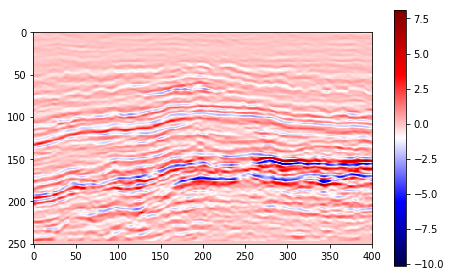

In [0]:
# seismic amplitudes
seismic_display(original_cube_amplitudes[76, :, :], figsize= (7.6,4.7), grid = False)

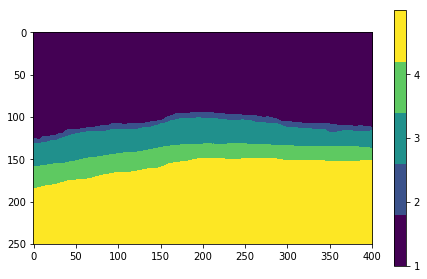

In [0]:
# Ground truth segmentaion map 
seismic_display(original_cube_labels[76, :, :], figsize= (7.6,4.7), grid = False, cmap = plt.cm.get_cmap(None, 5), ticks = np.linspace(0,4,5))

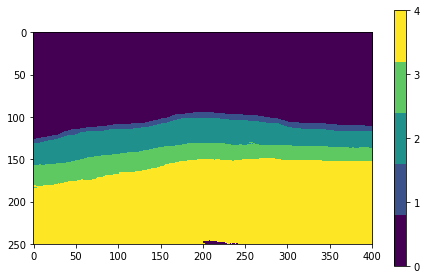

In [0]:
# predicted segmentaion map 
seismic_display(predicted_cube[76, :, :], figsize= (7.6,4.7), grid = False, cmap = plt.cm.get_cmap(None, 5), ticks = np.linspace(0,4,5))

overall accuracy is  0.9894747042142188
label0 accuracy is  0.9987052600372511
label1 accuracy is  0.916693929808559
label2 accuracy is  0.964954826860914
label3 accuracy is  0.9744470816631661
label4 accuracy is  0.9940796810039151


[0.9894747042142188,
 0.9987052600372511,
 0.916693929808559,
 0.964954826860914,
 0.9744470816631661,
 0.9940796810039151]

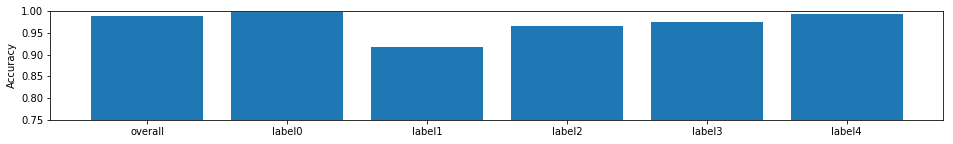

<Figure size 720x4320 with 0 Axes>

In [0]:
test_accuracy_score_volume(predicted_cube, original_cube_labels-1)

In [0]:
iou_accuracy(predicted_cube, original_cube_labels-1)

W0814 14:50:17.160578 140341671602048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:1178: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0814 14:50:17.162874 140341671602048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:1179: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


[0.94264525]
